# AIPI 590 - Explainable AI | Assignment #7

## Adversarial Patches

### Shaila Güereca

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shailajgg/Tryanderror/blob/main/a3.ipynb)


What is an Adversarial Attack? Is a technique that creates inputs designed to cause machine learning models to make mistakes

This notebook demonstrates how to create adversarial patches that can fool neural networks. An adversarial patch is a small image that, when placed within a larger image, causes a classifier to misidentify the entire image as a target class. 

At the end of the notebook you need to discover the secret password using a patch + an image, the word has _ _ _ _ _ _ _ _ letters. Cheers!

The code in this notebook was generated using Claude on 03/04/25 at 1:12 p.m.

## Steps
1. Load and prepare the dataset (TinyImageNet)
2. Set up a pretrained model (ResNet34)
3. Define functions for placing and evaluating patches
4. Train patches to target specific classes
5. Visualize and export the results

## 1. Environment setup
This section configures the necessary libraries, sets random seeds for reproducibility

In [1]:
## Standard libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import urllib.request
from urllib.error import HTTPError
import zipfile
from PIL import Image

## PyTorch imports
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['lines.linewidth'] = 2.0
plt.style.use('seaborn-v0_8-whitegrid')

# Set paths
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configure GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure deterministic operations on GPU
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cpu


## 2. Dataset preparation
Here we download the TinyImageNet dataset if not already present, and prepare to use a pretrained ResNet34 model

TinyImageNet is a smaller version of ImageNet with 200 classes and 500 images per class at 64x64 resolution

In [2]:
# Function to download and extract dataset files
def download_and_extract_files():
    """Download TinyImageNet dataset and pretrained patches if not already present."""
    # Github URL where the dataset is stored
    base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

    # Files to download
    pretrained_files = [
        (DATASET_PATH, "TinyImageNet.zip"),
        (CHECKPOINT_PATH, "patches.zip"),
    ]

    # Create directories if they don't exist
    os.makedirs(DATASET_PATH, exist_ok=True)
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)

    # Download and extract each file
    for dir_name, file_name in pretrained_files:
        file_path = os.path.join(dir_name, file_name)
        if not os.path.isfile(file_path):
            file_url = base_url + file_name
            print(f"Downloading {file_url}...")
            try:
                urllib.request.urlretrieve(file_url, file_path)
                print("Download complete.")
            except HTTPError as e:
                print(f"Download error: {e}")
                continue

            if file_name.endswith(".zip"):
                print("Extracting zip file...")
                with zipfile.ZipFile(file_path, "r") as zip_ref:
                    zip_ref.extractall(os.path.dirname(file_path))
                print("Extraction complete.")


# Download and extract necessary files
download_and_extract_files()

Download complete.
Extracting zip file...
Extraction complete.
Download complete.
Extracting zip file...
Extraction complete.


## 3. Model setup
We load a pretrained ResNet34 model and prepare it for the adversarial attack process. The model will be frozen (no gradient updates) as we're only modifying the input patches, not the model itself

In [3]:
# Load and prepare the ResNet34 model
def setup_model():
    """Load a pretrained ResNet34 model and prepare it for inference."""
    # Set torch home directory to find pretrained models
    os.environ["TORCH_HOME"] = CHECKPOINT_PATH

    # Load pretrained model
    model = torchvision.models.resnet34(weights="IMAGENET1K_V1")
    model = model.to(device)

    # Freeze model parameters - we're only training the patch
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    return model


# Initialize the model
pretrained_model = setup_model()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 26.7MB/s]


## 4. Dataset loading
We load the TinyImageNet dataset and prepare it for our experiments

In [4]:
# ImageNet normalization constants
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Create tensor versions of normalization constants for easier patch transformation
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN)[:, None, None]
TENSOR_STD = torch.FloatTensor(NORM_STD)[:, None, None]


def load_dataset():
    """Load and prepare the TinyImageNet dataset."""
    # Define image transformations
    transforms_pipeline = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
    )

    # Path to the dataset
    imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")

    # Verify dataset exists
    assert os.path.isdir(imagenet_path), f"Dataset not found at {imagenet_path}"

    # Load dataset
    dataset = torchvision.datasets.ImageFolder(
        root=imagenet_path, transform=transforms_pipeline
    )

    # Create data loader for full evaluation
    data_loader = data.DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
    )

    # Load class labels
    with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
        label_names = json.load(f)

    return dataset, data_loader, label_names


# Load the dataset and labels
dataset, data_loader, label_names = load_dataset()

# Show a sample of class names
random.seed(42)
sample_classes = random.sample(label_names, 10)
print("Sample classes from TinyImageNet:")
print(sample_classes)

Sample classes from TinyImageNet:
['minibus', 'slug', 'European fire salamander', 'reflex camera', 'tabby', 'Siberian husky', 'komondor', 'dowitcher', 'radio', 'wallaby']


## 5. Patch attack implementation
This section contains the core functions for creating and evaluating adversarial patches, we are going to train the patch to target the secret specific class and we will also evaluate how effectively this patch can fool the model 

In [5]:
def place_patch(img, patch):
    """
    Places a patch at random positions on each image in a batch.

    Args:
        img: Batch of images (B, C, H, W)
        patch: The adversarial patch (C, patch_H, patch_W)

    Returns:
        Modified batch of images with the patch applied
    """
    # Create a copy to avoid modifying the original images
    modified_img = img.clone()

    # Apply patch to each image in the batch at random locations
    for i in range(img.shape[0]):
        # Calculate valid placement ranges
        h_range = img.shape[2] - patch.shape[1]
        w_range = img.shape[3] - patch.shape[2]

        # Randomly select offset positions
        h_offset = np.random.randint(0, h_range)
        w_offset = np.random.randint(0, w_range)

        # Place the normalized patch
        modified_img[
            i,
            :,
            h_offset : h_offset + patch.shape[1],
            w_offset : w_offset + patch.shape[2],
        ] = patch_forward(patch)

    return modified_img


def patch_forward(patch):
    """
    Transforms patch parameters from unconstrained space to image space.

    Args:
        patch: Raw patch parameters

    Returns:
        Normalized patch values suitable for insertion into images
    """
    # Use tanh to constrain values between -1 and 1, then normalize to ImageNet range
    normalized_patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return normalized_patch


def eval_patch(model, patch, val_loader, target_class):
    """
    Evaluates how effectively a patch fools the model.

    Args:
        model: The target neural network
        patch: The adversarial patch
        val_loader: DataLoader for validation images
        target_class: The target class index

    Returns:
        Tuple of (top-1 accuracy, top-5 accuracy)
    """
    model.eval()

    # Counters for evaluation metrics
    top1_success = 0.0  # Count of top-1 successful attacks
    top5_success = 0.0  # Count of top-5 successful attacks
    total_valid = 0.0  # Count of valid test images (excluding target class)

    with torch.no_grad():
        for images, true_labels in tqdm(
            val_loader, desc="Evaluating patch", leave=False
        ):
            # Test each image with multiple random patch placements for robustness
            for _ in range(4):
                # Apply patch to images
                patched_images = place_patch(images, patch).to(device)
                true_labels = true_labels.to(device)

                # Get model predictions
                predictions = model(patched_images)

                # Create mask for valid images (excluding those already of target class)
                valid_mask = true_labels != target_class

                # Calculate successful attacks (where model predicts target class)
                top1_success += torch.logical_and(
                    predictions.argmax(dim=-1) == target_class, valid_mask
                ).sum()

                # Calculate top-5 successful attacks
                top5_success += torch.logical_and(
                    (predictions.topk(5, dim=-1)[1] == target_class).any(dim=-1),
                    valid_mask,
                ).sum()

                # Count total valid test examples
                total_valid += valid_mask.sum()

    # Calculate success rates
    top1_rate = top1_success / total_valid
    top5_rate = top5_success / total_valid

    return top1_rate, top5_rate


def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    """
    Trains an adversarial patch to target a specific class.

    Args:
        model: The target neural network
        target_class: The target class index
        patch_size: Size of the patch (square side length or tuple)
        num_epochs: Number of training epochs

    Returns:
        Tuple of (trained patch, validation results)
    """
    # Split dataset into training and validation sets
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = data.DataLoader(
        train_set,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
    )
    val_loader = data.DataLoader(
        val_set,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
    )

    # Ensure patch_size is a tuple
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    # Initialize patch parameters (trainable)
    patch = nn.Parameter(
        torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True
    )

    # Set up optimizer and loss function
    optimizer = optim.Adam([patch], lr=0.1)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        progress_bar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
        )

        for images, _ in progress_bar:
            # Apply patch to images
            patched_images = place_patch(images, patch)
            patched_images = patched_images.to(device)

            # Forward pass
            predictions = model(patched_images)

            # Create target labels (all images should be classified as target class)
            target_labels = torch.full(
                (images.shape[0],), target_class, device=device, dtype=torch.long
            )

            # Calculate loss
            loss = loss_module(predictions, target_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Evaluate final patch
    accuracy, top5 = eval_patch(model, patch, val_loader, target_class)
    results = {"acc": accuracy.item(), "top5": top5.item()}

    print(
        f"Attack success rate: {results['acc']*100:.2f}% (top-1), {results['top5']*100:.2f}% (top-5)"
    )

    return patch.data, results

## 6. Patch generation and evaluation
This section handles the loading, generation, and evaluation of adversarial patches for the secret target class

In [6]:
def get_patches(class_names, patch_sizes):
    """
    Generate or load adversarial patches for the specified classes and sizes.

    Args:
        class_names: List of target class names
        patch_sizes: List of patch sizes to generate

    Returns:
        Dictionary containing patches and their evaluation results
    """
    result_dict = {}

    # Try to load existing results
    json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
    json_results = {}
    if os.path.isfile(json_results_file):
        with open(json_results_file, "r") as f:
            json_results = json.load(f)

    # Process each class and patch size
    for name in class_names:
        result_dict[name] = {}
        for patch_size in patch_sizes:
            print(f"\nProcessing {name} patch of size {patch_size}×{patch_size}")

            # Get class index
            class_index = label_names.index(name)

            # File path for saved patch
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

            # Either load existing patch or train a new one
            if os.path.isfile(file_name):
                print(f"Loading existing patch from {file_name}")
                patch = torch.load(file_name)

                # Load or compute evaluation results
                if name in json_results and str(patch_size) in json_results[name]:
                    results = json_results[name][str(patch_size)]
                    print(f"Using cached evaluation results: {results}")
                else:
                    print("Evaluating patch...")
                    results = eval_patch(
                        pretrained_model, patch, data_loader, target_class=class_index
                    )
                    print(f"Evaluation results: {results}")
            else:
                print(
                    f"Training new patch for class '{name}' with size {patch_size}..."
                )
                patch, results = patch_attack(
                    pretrained_model,
                    target_class=class_index,
                    patch_size=patch_size,
                    num_epochs=5,
                )
                print(f"Saving patch to {file_name}")
                torch.save(patch, file_name)

            # Store results
            result_dict[name][patch_size] = {"results": results, "patch": patch}

    return result_dict


def save_results(patch_dict):
    """Save patch evaluation results to a JSON file."""
    result_dict = {
        cname: {
            str(psize): [
                t.item() if isinstance(t, torch.Tensor) else t
                for t in patch_dict[cname][psize]["results"]
            ]
            for psize in patch_dict[cname]
        }
        for cname in patch_dict
    }

    output_path = os.path.join(CHECKPOINT_PATH, "patch_results.json")
    with open(output_path, "w") as f:
        json.dump(result_dict, f, indent=4)

    print(f"Results saved to {output_path}")


# Define target class and patch size
class_names = ["cock"]  # Target class (rooster)
patch_sizes = [64]  # Patch dimensions in pixels

# Generate or load patches
patch_dict = get_patches(class_names, patch_sizes)

# Uncomment to save results
# save_results(patch_dict)


Processing cock patch of size 64×64
Training new patch for class 'cock' with size 64...


Epoch 1/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/140 [00:00<?, ?it/s]

Evaluating patch:   0%|          | 0/16 [00:00<?, ?it/s]

Attack success rate: 99.35% (top-1), 100.00% (top-5)
Saving patch to ../saved_models/tutorial10/cock_64_patch.pt


## 7. Visualization
This section provides functions to visualize the generated patches

In [ ]:
def visualize_patch(patch_dict, class_name, patch_size):
    """
    Display the adversarial patch.

    Args:
        patch_dict: Dictionary containing patches
        class_name: Target class name
        patch_size: Size of the patch to visualize
    """
    # Get the patch data
    patch = patch_dict[class_name][patch_size]["patch"]

    # Convert from parameter space to image space (0-1 range)
    patch_img = (torch.tanh(patch) + 1) / 2

    # Convert to numpy for display
    patch_np = patch_img.cpu().permute(1, 2, 0).numpy()
    patch_np = np.clip(patch_np, 0.0, 1.0)

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(patch_np)
    plt.title(
        f"Adversarial patch targeting class: {class_name}\nSize: {patch_size}×{patch_size} pixels"
    )
    plt.axis("off")
    plt.show()

    # Get success rate
    results = patch_dict[class_name][patch_size]["results"]
    if isinstance(results, (list, tuple)):
        success_rate = results[0] * 100
    else:
        success_rate = results["acc"] * 100

    print(
        f"This patch causes the model to classify any image as '{class_name}' with {success_rate:.2f}% success rate"
    )


def export_patch_image(
    patch_dict, class_name, patch_size, save_path="adversarial_patch.jpg"
):
    """
    Export the adversarial patch as a standard image file and display it alongside a tail.png image.

    Args:
        patch_dict: Dictionary containing patches
        class_name: Target class name
        patch_size: Size of the patch to export
        save_path: Output file path
    """
    import os

    # Print current working directory for debugging
    current_dir = os.getcwd()
    print(f"Current working directory: {current_dir}")

    # Use absolute path to ensure correct save location
    abs_save_path = os.path.join(current_dir, save_path)

    # Get the patch
    patch = patch_dict[class_name][patch_size]["patch"]

    # Convert from parameter space to image space (0-1 range)
    patch_img = (torch.tanh(patch) + 1) / 2
    patch_np = patch_img.cpu().permute(1, 2, 0).numpy()

    # Scale to 0-255 range for standard RGB
    patch_np = (patch_np * 255).astype(np.uint8)

    # Create a larger white background
    img_size = 224  # Standard size for many models
    background = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

    # Center the patch
    h_start = (img_size - patch_np.shape[0]) // 2
    w_start = (img_size - patch_np.shape[1]) // 2

    # Place patch on background
    background[
        h_start : h_start + patch_np.shape[0],
        w_start : w_start + patch_np.shape[1],
        :,
    ] = patch_np

    try:
        # Create and save image
        pil_img = Image.fromarray(background, mode="RGB")
        pil_img.save(abs_save_path, format="JPEG", quality=95)

        # Also save as PNG (lossless)
        png_path = abs_save_path.replace(".jpg", ".png")
        pil_img.save(png_path, format="PNG")

        print(f"✅ Patch exported as JPEG: {abs_save_path}")
        print(f"✅ Patch exported as PNG: {png_path}")

        # Verify files were created
        print(f"JPEG file exists: {os.path.exists(abs_save_path)}")
        print(f"PNG file exists: {os.path.exists(png_path)}")
    except Exception as e:
        print(f"❌ Error saving image: {e}")

    # Display the exported adversarial patch
    plt.figure(figsize=(8, 8))
    plt.imshow(background)
    plt.title("Exported Adversarial Patch")
    plt.axis("off")
    plt.show()

    # Check if tail.png exists in current directory
    tail_path = os.path.join(current_dir, "tail.png")
    print(f"Looking for tail.png at: {tail_path}")
    print(f"tail.png exists: {os.path.exists(tail_path)}")

    # Display tail.png if it exists
    if os.path.exists(tail_path):
        try:
            tail_img = Image.open(tail_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(np.array(tail_img))
            plt.title("Tail Image")
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"❌ Error displaying tail.png: {e}")
    else:
        print("❌ tail.png not found in the current directory")

Current working directory: /Users/shailaguereca/Documents/AIPI 590 Explainable AI/AIPI590_Explainable_AI/Optimizado
patch_dict exists: True
class_names exists: True
patch_sizes exists: True
Using class_name: cock, patch_size: 64
patch_dict has class 'cock': True
patch_dict['cock'] has size '64': True
✅ Adversarial patch image saved to: /Users/shailaguereca/Documents/AIPI 590 Explainable AI/AIPI590_Explainable_AI/Optimizado/adversarial_patch.jpg
File exists: True


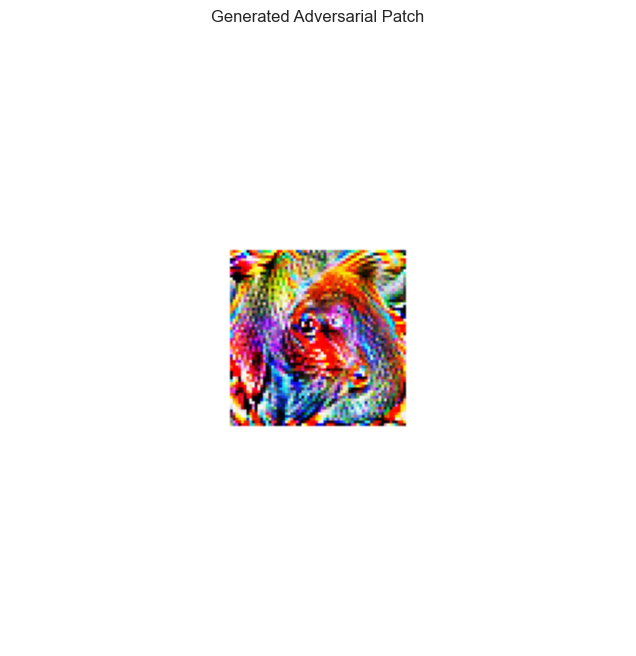

In [ ]:
# Run this in a new cell to generate the adversarial patch image directly
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Get current directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Check if patch_dict exists and has the required structure
try:
    # Verify patch_dict is defined and has the expected structure
    # This assumes you've already run the code that creates patch_dict
    print(f"patch_dict exists: {'patch_dict' in globals()}")

    if "patch_dict" in globals():
        # Check if class_names and patch_sizes are defined
        print(f"class_names exists: {'class_names' in globals()}")
        print(f"patch_sizes exists: {'patch_sizes' in globals()}")

        if "class_names" in globals() and "patch_sizes" in globals():
            class_name = class_names[0]
            patch_size = patch_sizes[0]
            print(f"Using class_name: {class_name}, patch_size: {patch_size}")

            # Check if the class_name and patch_size keys exist in patch_dict
            has_class = class_name in patch_dict
            has_size = has_class and patch_size in patch_dict[class_name]
            print(f"patch_dict has class '{class_name}': {has_class}")
            print(f"patch_dict['{class_name}'] has size '{patch_size}': {has_size}")

            if has_size:
                # Get the patch data
                patch = patch_dict[class_name][patch_size]["patch"]

                # Convert from parameter space to image space (0-1 range)
                patch_img = (torch.tanh(patch) + 1) / 2
                patch_np = patch_img.cpu().permute(1, 2, 0).numpy()

                # Scale to 0-255 range for RGB
                patch_np = (patch_np * 255).astype(np.uint8)

                # Create a larger white background
                img_size = 224  # Standard size for many models
                background = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255

                # Center the patch
                h_start = (img_size - patch_np.shape[0]) // 2
                w_start = (img_size - patch_np.shape[1]) // 2

                # Place patch on background
                background[
                    h_start : h_start + patch_np.shape[0],
                    w_start : w_start + patch_np.shape[1],
                    :,
                ] = patch_np

                # Define the save path for adversarial_patch.jpg
                save_path = os.path.join(current_dir, "adversarial_patch.jpg")

                # Try to save the image
                try:
                    pil_img = Image.fromarray(background, mode="RGB")
                    pil_img.save(save_path, format="JPEG", quality=95)
                    print(f"✅ Adversarial patch image saved to: {save_path}")
                    print(f"File exists: {os.path.exists(save_path)}")

                    # Show the image that was just saved
                    plt.figure(figsize=(8, 8))
                    plt.imshow(background)
                    plt.title("Generated Adversarial Patch")
                    plt.axis("off")
                    plt.show()
                except Exception as e:
                    print(f"❌ Error saving adversarial patch: {e}")
        else:
            print("❌ class_names or patch_sizes variables not found")
    else:
        print(
            "❌ patch_dict variable not found - make sure you've run the cell that creates it"
        )

except Exception as e:
    print(f"❌ Error during verification: {e}")

Adversarial patch exists: True
Tail image exists: True
✅ Combined image saved to: /Users/shailaguereca/Documents/AIPI 590 Explainable AI/AIPI590_Explainable_AI/Optimizado/adversarial_patch_with_tail.jpg


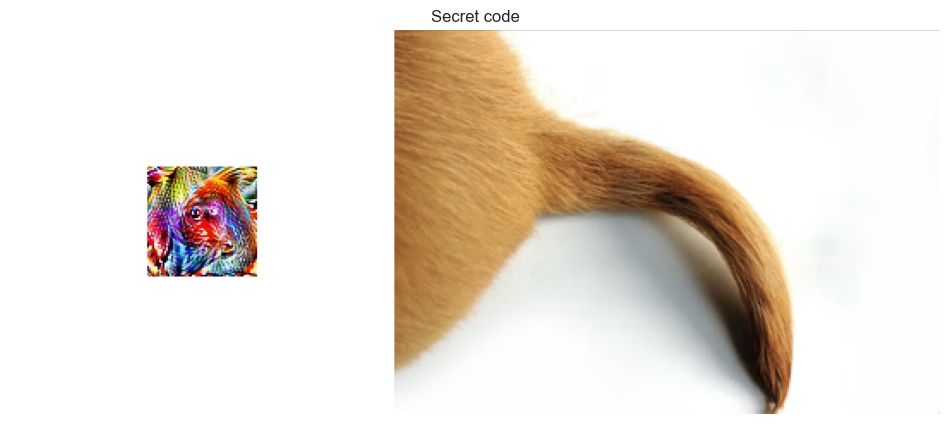

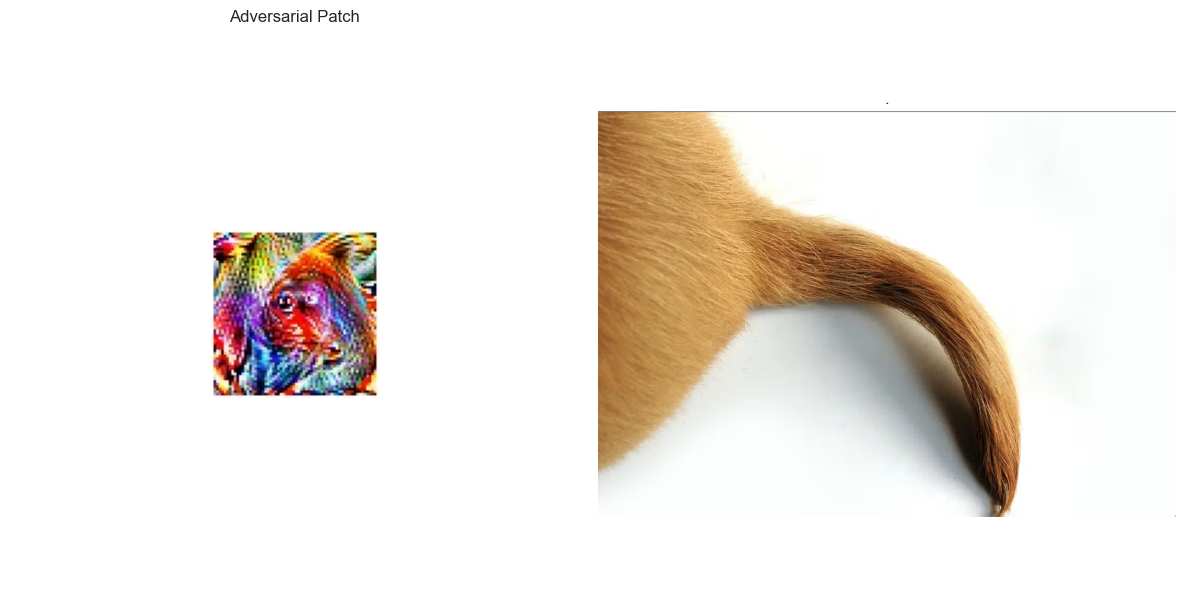

In [ ]:
# Run this in a new cell to create a side-by-side image with adversarial patch and tail.png
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

current_dir = os.getcwd()
adv_patch_path = os.path.join(current_dir, "adversarial_patch.jpg")
tail_path = os.path.join(current_dir, "tail.png")

# Check if both images exist
adv_exists = os.path.exists(adv_patch_path)
tail_exists = os.path.exists(tail_path)

print(f"Adversarial patch exists: {adv_exists}")
print(f"Tail image exists: {tail_exists}")

if adv_exists and tail_exists:
    try:
        # Load both images
        adv_img = Image.open(adv_patch_path)
        tail_img = Image.open(tail_path)

        # Convert to RGB if needed
        if adv_img.mode != "RGB":
            adv_img = adv_img.convert("RGB")
        if tail_img.mode != "RGB":
            tail_img = tail_img.convert("RGB")

        # Resize tail image to match height of adversarial patch
        adv_width, adv_height = adv_img.size
        tail_width, tail_height = tail_img.size

        # Calculate new size for tail image to maintain aspect ratio and match height
        new_tail_width = int((adv_height / tail_height) * tail_width)
        tail_img_resized = tail_img.resize((new_tail_width, adv_height))

        # Create a new image with space for both images side by side
        combined_width = adv_width + new_tail_width
        combined_height = adv_height
        combined_img = Image.new(
            "RGB", (combined_width, combined_height), (255, 255, 255)
        )

        # Paste both images
        combined_img.paste(adv_img, (0, 0))
        combined_img.paste(tail_img_resized, (adv_width, 0))

        # Save the combined image
        combined_path = os.path.join(current_dir, "adversarial_patch_with_tail.jpg")
        combined_img.save(combined_path, format="JPEG", quality=95)
        print(f"✅ Combined image saved to: {combined_path}")

        # Display the combined image
        plt.figure(figsize=(12, 6))
        plt.imshow(np.array(combined_img))
        plt.title("Secret code")
        plt.axis("off")
        plt.show()

        # Also display images side by side using matplotlib
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(np.array(adv_img))
        ax1.set_title("Adversarial Patch")
        ax1.axis("off")

        ax2.imshow(np.array(tail_img))
        ax2.set_title(".")
        ax2.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error creating combined image: {e}")
else:
    print("❌ One or both required images not found.")

    # If at least one exists, show that one
    if adv_exists:
        try:
            img = Image.open(adv_patch_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(np.array(img))
            plt.title("Adversarial Patch")
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"❌ Error displaying adversarial patch: {e}")

    if tail_exists:
        try:
            img = Image.open(tail_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(np.array(img))
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"❌ Error displaying tail image: {e}")

## 8. Conclusion

We've created an adversarial patch that have a secret message. This demonstrates a vulnerability in neural networks since they can be manipulated with small, carefully crafted inputs. But understanding these vulnerabilities helps develop more robust models



### Credits

This tutorial was originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University. This notebook is a further adaptation of their work

## Source Notebooks
- **Dr. Brinnae Bent's notebook:** [Duke-AI-XAI Adversarial Attacks & Patches](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks_patches.ipynb)
- **Phillip Lippe's original notebook:** 
  [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
  [![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)

## References
[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.